# Generate results comparing linear regression and geodesic regression between $q^{\text{ref}}$ and $q$

In [1]:
COL_TO_TEXT = {
    "diff_seq_per_time_vertex_diameter": "Mesh distance per vertex [% diameter]",
    "diff_seq_duration_per_time_and_vertex": "Time difference [secs] per mesh and vertex",
    "relative_diff_seq_duration": "Time difference per vertex [% line]",
    "noise_factor": "Deformation factor, Steps",
    "n_steps": "Number of steps",
    "n_vertices": "Number of vertices",
}

In [2]:
import numpy as np
import pandas as pd

# Load real and synthetic run tables

We load the .csv that corresponds to the wandb Table downloaded from:

https://wandb.ai/bioshape-lab/my28brains-my28brains/table?workspace=user-adelemyers

(note, we have added filters: `use_parka` = `false`, and `full_run` = `null` or `true`)

In [5]:
synthetic_df = pd.read_csv("synthetic_linear_vs_geodesic_regression.csv")
synthetic_df.head()

,Name,State,Notes,User,Tags,Created,Runtime,dataset_name,end_shape,euclidean_subspace,...,geodesic_duration_time,geodesic_intercept_err,geodesic_tol,linear_coef_err,linear_duration_time,linear_intercept_err,mesh_diameter,ellipse_ratio_h_v,n_faces,test_diff_tolerance
0,run_iefgn7q3,finished,-,adelemyers,NaN,2023-07-07T18:04:44.000Z,575,synthetic,ellipsoid,False,...,432.098236,5.656766e-09,4.306538e+14,1.211099e-08,260.524600,5.656766e-09,1620000.0,0.666667,5120.0,1620.0
1,run_ijkw50rh,finished,-,adelemyers,NaN,2023-07-07T17:56:38.000Z,423,synthetic,ellipsoid,False,...,262.057967,3.411245e+03,3.004676e+10,2.456509e+04,112.852549,3.411245e+03,54000.0,5.000000,1280.0,54.0
2,run_ctkcg2xc,finished,-,adelemyers,NaN,2023-07-07T17:48:49.000Z,467,synthetic,ellipsoid,False,...,314.177742,3.386882e+03,3.004676e+10,1.693441e+04,174.833930,3.386882e+03,54000.0,0.200000,1280.0,54.0
3,run_nwkqq7oh,finished,-,adelemyers,NaN,2023-07-07T17:39:57.000Z,530,synthetic,ellipsoid,False,...,347.132451,8.633496e-11,3.004676e+10,1.980528e-10,174.721431,8.633496e-11,54000.0,0.666667,1280.0,54.0
4,run_wxl5wxwq,finished,-,adelemyers,NaN,2023-07-07T17:34:14.000Z,315,synthetic,ellipsoid,False,...,239.858614,3.450211e+03,2.125764e+06,4.644987e+04,176.224559,3.450211e+03,1800.0,5.000000,320.0,1.8


The columns of the dataframe corresponding to the .csv are the variables that we have logged into wandb:

In [4]:
df.columns

Index(['Name', 'State', 'Notes', 'User', 'Tags', 'Created', 'Runtime',
       'dataset_name', 'end_shape', 'full_run', 'use_parka',
       'geodesic_initialization', 'geodesic_residuals', 'n_times',
       'noise_factor', 'sped_up', 'start_shape', 'ellipse_dimensions',
       'n_steps', 'n_subdivisions', 'tol_factor',
       'euclidean_subspace_via_diffs', 'euclidean_subspace_via_ratio',
       'geodesic_coef_err', 'geodesic_duration_time', 'geodesic_intercept_err',
       'geodesic_tol', 'linear_coef_err', 'linear_duration_time',
       'linear_intercept_err', 'mesh_diameter', 'ellipse_ratio_h_v', 'n_faces',
       'test_diff_tolerance'],
      dtype='object')

# Save linear and geodesic mesh arrays
## - NOTE: run this on frank for synthetic data, run on parka for real data!!!

We want to investigate the ERROR and speed of:
- geodesic regression (with, without) linear warm-start
- gr vs lr with different levels of (noise, subdivisions, n_times, end_point)

Currently, our computation of error uses distance, but we rather wish to use mesh differeneces. we will have to compute this.

wandb data for each run is saved in /home/adele/code/my28brains/wandb

/home/adele/code/my28brains/wandb/run-20230704_080429-3200wflw/files/media

## Synthetic

In [43]:
import os
import json
import numpy as np

wandb_path = '/home/adele/code/my28brains/wandb'
valid_file_prefixes = [
    'geodesic_coef_hat_2',
    'geodesic_intercept_hat_2',
    'linear_coef_hat_1',
    'linear_intercept_hat_1',
    'meshes_along_geodesic_regression_2',
    'meshes_along_linear_regression_1',
    'mesh_sequence_vertices_0',
    'offset_mesh_sequence_vertices_1',
    'true_coef_1',
    'true_intercept_1'
]

run_names = []

for root, dirs, files in os.walk(wandb_path):
    for directory in dirs:
        if directory.startswith('run-'):
            run_names.append(directory)

output_folder = '/home/adele/code/my28brains/my28brains/notebooks/synthetic_mesh_vertices_arrays'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for run_name in run_names:
    run_path = os.path.join(wandb_path, run_name)
    media_folder_path = os.path.join(run_path, 'files', 'media', 'object3D')
    if os.path.exists(media_folder_path):
        for file in os.listdir(media_folder_path):
            if any(file.startswith(valid_file) for valid_file in valid_file_prefixes):
                file_path = os.path.join(media_folder_path, file)
                output_file_name = os.path.splitext(file)[0]  # Extract the file name without extension
                output_file_name = output_file_name.replace('.pts', '')  # Remove .pts from the file name
                output_file_path = os.path.join(output_folder, output_file_name)

                try:
                    # Process the JSON file and save the necessary information as a NumPy array
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                        np_array = np.array(data)

                    # Save the array as a NumPy file with .npy extension
                    np.save(output_file_path, np_array)

                    print(f"Saved array: {output_file_name}")
                except Exception as e:
                    print(f"Skipping file: {file} due to {type(e).__name__} error.")

print("Extraction completed.")


Saved array: true_intercept_1_4b9598ff0d926ee06b2c
Saved array: geodesic_coef_hat_2_a728715801e2c95b3fbf
Saved array: true_coef_1_2f46fb8b88554b220df4
Saved array: geodesic_intercept_hat_2_b634cd23c8e0ada8626d
Saved array: linear_coef_hat_1_a728715801e2c95b3fbf
Saved array: offset_mesh_sequence_vertices_1_84e3ac267d6e0bf776f5
Saved array: linear_intercept_hat_1_b634cd23c8e0ada8626d
Saved array: linear_coef_hat_1_6b8628084aa4767c6e3c
Saved array: true_intercept_1_2aeb50e5af3a68b3d6cc
Saved array: geodesic_intercept_hat_2_551e1e7a301d28eb3af9
Saved array: geodesic_coef_hat_2_6b8628084aa4767c6e3c
Saved array: true_coef_1_7a521e3e212f3befd831
Saved array: linear_intercept_hat_1_551e1e7a301d28eb3af9
Saved array: offset_mesh_sequence_vertices_1_0f54c6279ea9f5cd9cc1
Saved array: true_coef_1_93d2baa8393b444c69f9
Saved array: true_intercept_1_aca6a37991b49b6058b7
Saved array: geodesic_coef_hat_2_f23df5cf69525e05c399
Saved array: linear_intercept_hat_1_70c7de875443d2a3fb4f
Saved array: linear_co

## Test to see whether synthetic data is load-able

In [44]:
import os
import numpy as np

output_folder = '/home/adele/code/my28brains/my28brains/notebooks/synthetic_mesh_vertices_arrays'

output_files = os.listdir(output_folder)

for file in output_files:
    file_path = os.path.join(output_folder, file)
    if file.endswith('.npy'):
        try:
            loaded_array = np.load(file_path)
            print(f"Loaded array from {file}:")
            print(loaded_array)
        except Exception as e:
            print(f"Error loading array from {file}: {type(e).__name__}")

print("Loading completed.")


Loaded array from geodesic_intercept_hat_2_9e89290d7ffe3f1fa72a.npy:
[[-1.59618274e+01  2.46686720e+01 -3.46679414e-01]
 [ 1.48819867e+01  2.40803675e+01  6.48775980e-01]
 [-1.44011696e+01 -2.44566250e+01  7.42370171e-02]
 [ 1.56561217e+01 -2.50643172e+01  1.54038335e-02]
 [ 6.27976283e-01 -1.51958889e+01  2.69907467e+01]
 [-5.31716419e-01  1.54210510e+01  2.66479317e+01]
 [ 1.36935739e-01 -1.54252684e+01 -2.71125905e+01]
 [ 3.81980102e-01  1.51193061e+01 -2.66790094e+01]
 [ 2.45111655e+01 -3.65133175e-01 -1.61017023e+01]
 [ 2.49876221e+01  4.61525112e-01  1.62880265e+01]
 [-2.41797618e+01  1.30127633e-01 -1.63539107e+01]
 [-2.40502859e+01  2.43105380e-01  1.65692406e+01]
 [-8.89094511e-01  2.94503570e+01 -4.49307878e-01]
 [-7.08833025e-03 -2.97842129e+01  4.68719320e-01]
 [-8.44124628e+00 -2.33263521e+01  1.63956930e+01]
 [ 9.37589712e+00 -2.39114558e+01  1.53403676e+01]
 [-8.31425992e+00  2.50273522e+01  1.58114075e+01]
 [ 8.82556394e+00  2.36059184e+01  1.63228321e+01]
 [-3.48405908

## Real Data - Run on Parka

In [ ]:
import os
import json
import numpy as np

wandb_path = '/home/adele/code/my28brains/wandb'
valid_file_prefixes = [
    'geodesic_coef_hat_2',
    'geodesic_intercept_hat_2',
    'linear_coef_hat_1',
    'linear_intercept_hat_1',
    'meshes_along_geodesic_regression_2',
    'meshes_along_linear_regression_1',
    'mesh_sequence_vertices_0',
    'offset_mesh_sequence_vertices_1',
    'true_coef_1',
    'true_intercept_1'
]

run_names = []

for root, dirs, files in os.walk(wandb_path):
    for directory in dirs:
        if directory.startswith('run-'):
            run_names.append(directory)

output_folder = '/home/adele/code/my28brains/my28brains/notebooks/real_mesh_vertices_arrays'

if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for run_name in run_names:
    run_path = os.path.join(wandb_path, run_name)
    media_folder_path = os.path.join(run_path, 'files', 'media', 'object3D')
    if os.path.exists(media_folder_path):
        for file in os.listdir(media_folder_path):
            if any(file.startswith(valid_file) for valid_file in valid_file_prefixes):
                file_path = os.path.join(media_folder_path, file)
                output_file_name = os.path.splitext(file)[0]  # Extract the file name without extension
                output_file_name = output_file_name.replace('.pts', '')  # Remove .pts from the file name
                output_file_path = os.path.join(output_folder, output_file_name)

                try:
                    # Process the JSON file and save the necessary information as a NumPy array
                    with open(file_path, 'r') as f:
                        data = json.load(f)
                        np_array = np.array(data)

                    # Save the array as a NumPy file with .npy extension
                    np.save(output_file_path, np_array)

                    print(f"Saved array: {output_file_name}")
                except Exception as e:
                    print(f"Skipping file: {file} due to {type(e).__name__} error.")

print("Extraction completed.")


In [30]:
# import wandb

# def extract_file_with_array(run_path, output_path):
#     run = wandb.init(id=run_path, resume=False)
#     media_files = run.files()
#     for media_file in media_files:
#         if media_file.name == 'file_with_array.json':
#             media_file.download(root=output_path, replace=True)
#             break
#     wandb.finish()

# # Example usage
# wandb.init()  # Initialize wandb
# api = wandb.Api()
# username = "adelemyers"
# project_name = "bioshape-lab/my28brains-my28brains"
# runs = api.runs("{}/{}/all".format(username, project_name))
# output_path = "/home/adele/code/my28brains/my28brains/notebooks/mesh_vertex_arrays/"

# for run in runs:
#     run_path = "{}/{}/{}".format(username, project_name, run.id)
#     extract_file_with_array(run_path, output_path)


We can plot histograms of some of these variables to get intuition of their values.

Here, we plot how long is takes to compute one line between two meshes, per vertex. We see that it takes less than 1 microsecond per vertex, i.e. less than 5 seconds to compute a line between two meshes that has 5 mesh along the sequence and these meshes have 1000 vertices.

TODO: FROM HERE DOWN, CHANGE FOR REGRESSION ANALYSIS

In [7]:
line_duration_per_time_vertex = df["line_duration"] / (df["n_vertices"] * df["n_times"])
print("Average:", line_duration_per_time_vertex.mean())
line_duration_per_time_vertex.hist(figsize=(2, 2));

KeyError: 'line_duration'

We compare the time taken to compute a line versus a geodesic between two meshes.

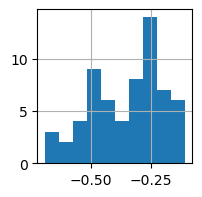

In [6]:
df["diff_seq_duration_per_time_and_vertex"].hist(figsize=(2, 2));

## Histograms

We write a function that can plot more sophisticated histograms, by grouping according to a given variable `by`.

In [35]:
import plotly.graph_objects as go


def hist_diff_seq_per_time_vertex_diameter_group(by="n_steps"):
    grouped_data = df.groupby(by)["diff_seq_per_time_vertex_diameter"]

    fig = go.Figure()

    for name, group in grouped_data:
        fig.add_trace(go.Histogram(x=group, opacity=0.5, name=f"{by} = {name}"))

    fig.update_layout(
        title=COL_TO_TEXT["diff_seq_per_time_vertex_diameter"],
        showlegend=True,
        width=600,  # Set the width of the figure to 500
        height=400, 
    )

    fig.show()

In [36]:
hist_diff_seq_per_time_vertex_diameter_group(by="n_steps")

In [37]:
hist_diff_seq_per_time_vertex_diameter_group(by="n_vertices")

In [38]:
hist_diff_seq_per_time_vertex_diameter_group(by="noise_factor")

## Scatter plots

We write code to generate the main plot for the corresponding section of the paper.

In [55]:
import plotly.express as px
import plotly.io as pio

fontsize = 15

def diff_scatter_grouped(
    colored_by="noise_factor",
    marked_by="n_steps",
    diff_seq="relative_diff_seq_duration",
):
    x = df["diff_seq_per_time_vertex_diameter"] * 100
    y = np.abs(df[diff_seq]) / df["n_vertices"]
    value_to_symbol = dict(zip(df[marked_by].unique(), ["square", "x", "cross"]))

    fig = px.scatter(
        df,
        x=x,
        y=y,
        color=[str(c) for c in df[colored_by].values],
        color_discrete_sequence=px.colors.qualitative.Dark24,  # D3 #Dark24 # Pastel
        symbol=[s for s in df[marked_by].values],
        symbol_map=value_to_symbol,
    )

    fig.update_layout(
        xaxis_title=dict(
            text=COL_TO_TEXT["diff_seq_per_time_vertex_diameter"],
            font=dict(family="CMU", size=fontsize),
        ),
        yaxis_title=dict(text=COL_TO_TEXT[diff_seq], font=dict(family="CMU", size=fontsize)),
        title_font=dict(family="CMU", size=fontsize),
        xaxis=dict(tickfont=dict(family="CMU", size=fontsize)),
        yaxis=dict(tickfont=dict(family="CMU", size=fontsize)),
        legend=dict(font=dict(family="CMU", size=fontsize), title=COL_TO_TEXT[colored_by]),
        width=650,
        height=370,
    )

    fig.update_traces(marker=dict(size=9, opacity=0.9))
    pio.write_image(fig, f"line_vs_geodesic_colored_by_{colored_by}.svg")
    fig.show()

In [44]:
diff_scatter_grouped(colored_by="noise_factor", marked_by="n_steps")

In [56]:
diff_scatter_grouped(colored_by="n_vertices", marked_by="n_steps")